# BILSTM with attention mechnism for relation classification

In an automotive part manufacturing industry, there is possibility of product recalls due to a variety of reasons. Some of the reasons include internal or external part damage, mistakes in packaging process, poor internal management etc. However, identifying quality defects is often the most difficult and the most critical for the producer. 

There are various problem solving process to handle product returns. A problem is defined as a deviation from a defined target situation, there are many ways to for problem solving and one such method of problem solving is 8D process, it defines 8 steps which includes not just solving the problem but also a root cause analysis so that the problem does not reoccur again and also a containment action to limit the problem and resume normal operations. However, each and every product already has an fmea, an fmea pre-defines defines risk analysis, or the probable risk and failures a product can have, and there is a possiblity the the root cause might be defined in FMEA. 

Since, most of it is in textual format and need domain expertise to search through an FMEA or perform a root cause analysis of the problem from scratch. Therefore, structuring of fmea contents can significantly improve the quality of 8D process and can also act as the basis for other applications. 

A common approach for structuring of documents is to build a Named-entity recognition model for detecting the parts and subparts in each and every sentence of an fmea document. An addition to named entity recognition is also relationship extraction where we identify the relation of potential failure or function of the entity. 

### For example "Grease seals of motor interior." 
In this case "Grease" is identified as an entity also "motor interior" is also an subpart of the motor. 
This has a cause effect relationship, which means "Grease" has a sealing effect on "motor Interior". 
Therefore, relation extraction task will extract, 

Cause-effect(Grease,motor interior) 
Here, is an attempt to build an end-to-end entity and relationship extraction. 

In [ ]:
# import pandas as pd
from lxml import etree
import xml.etree.ElementTree as ET
import csv

#data = "C:/Path/test.xml"

data = "C:/Users/akr2bue/pythonscript/mypythondata/bearingbolt.xml"
tree = ET.parse(data)
root = tree.getroot()

The FMEA is written in special software called IQRM, which consist of all the necessary fields to write the document. 
The first task was to export the FMEA into an XML file.
Then the reference number for each of the failure sentence and the sentence itself was converted into a csv file. 

In [ ]:
allbearingdata = open('C:/Users/akr2bue/pythonscript/mypythondata/bearingcsvfuncfault2.csv', 'w')
csvwriter = csv.writer(allbearingdata)
resident_head = [] 

count = 0
funccount =0 
for member in root.findall('FM-FUNCTIONS'):
    address_list = []
    resident = [] 
    longname = []
    funcid = []
    if count == 0:
        struct = ("Function Key")
        resident_head.append(struct)
        structtext = ("Function text ")
        resident_head.append(structtext)
        Funkey = ("Fault Key")
        resident_head.append(Funkey)
        #funid = ("Function ID")
        csvwriter.writerow(resident_head)
        count = count + 1
        
    for member in root.iter('FM-FUNCTION'):
        struidnum = member.get('ID')
        #resident.append(struidnum)
        for member1 in member.iter('LONG-NAME'):
            abc = member1.find('L-4').text
            #resident.append(abc)
            for member2 in member.iter('FM-FAULT-REFS'):
                for member3 in member2.iter('FM-FAULT-REF'):
                    bnd = member3.get('ID-REF')
                    resident.append(struidnum)
                    resident.append(abc)
                    resident.append(bnd)
                    #funccount = funccount + 1
                    csvwriter.writerow(resident)
                    resident = []
                if funccount > 0:
                    break
allbearingdata.close()

The file was preprocess to include sentence, the 2 entities contained in the sentence and the relationship between the entities. 

In [214]:
with open("fpg3_test_v2_2208.tsv") as f:
    test_file = f.readlines()

It is important to note that, initially an attempt was made to create ontology based on the sentences in fmea. 
### For example "FPG3-quadripole drive converts the electrical power to mechanical power with an objective to provide the defined rotation speed" 
Here FPG3-quadripole drive is "entity 1" and "mechanical power" is "entity 2", the relation is that of a producer and a product. As mechanical power is generated from quadripole drive. 
Due, to lack of existing ontology an end-to-end model was defined such that both the entities and also the relationship between them needs to be extracted. 

In [215]:
from itertools import islice
with open("fpg3_test_v2_2208.tsv") as myfile:
    head = list(islice(test_file, 5))
print(head)

['1\t<e1> FPG3-quadripole </e1> drive converts the electrical power to <e2> mechanical power </e2> with an objective to provide the defined rotation speed of the rope drum in case of defined operational torque (characteristic curve).\tProduct-Producer\n', '3\tFPG3-quadripole drive converts the electrical power to <e1> mechanical power </e1> with an objective to provide the defined rotation speed of the rope drum in case of defined <e2> operational torque </e2> (characteristic curve).\tProduct-Producer\n', '4\tFPG3-quadripole drive converts the <e1> electrical power </e1> to mechanical power with an objective to provide the defined rotation speed of the rope drum in case of defined operational torque (characteristic curve).\tCause-Effect\n', '5\t<e1> FPG3-quadripole </e1> drive generates a <e2> rotary movement </e2> in a defined direction depending on the polarity of input voltage (rotation direction standards)\tProduct-Producer\n', '6\tFPG3-quadripole drive generates a rotary movement 

Above shows sentence and relation between entities, Below we prepare sentences and relations training file. 

In [216]:
def prepare_dataset_sen(raw_data):
    sentences = []
    for l in raw_data:
        sl = l.split("\t")
        if sl[0].isdigit():
            sent = sl[1]
            sentences.append(sent)
    print("Found {} sentences".format(len(sentences)))
    return sentences

In [217]:
def prepare_dataset_rel(raw_data):
    relations =  []
    for line in raw_data:
        sl = line.split("\t")
        if sl[0].isdigit():
            rel = sl[2]
            rel = rel.replace("\n", "")
            relations.append(rel)
    print("Found {} relations".format(len(relations)))
    return relations

Here we obtain all the sentences using prepare_dataset_sen method

In [218]:
test_sent = prepare_dataset_sen(test_file)

Found 233 sentences


Here we obtain all the sentences using prepare_dataset_rel method

In [219]:
test_rel = prepare_dataset_rel(test_file)

Found 233 relations


The number of relations and type of relations can be seen here 

In [220]:
n_rel_test_file = len(set(test_rel))
print("Found {} relations\n".format(n_rel_test_file))
print("Relations:\n{}".format(list(set(test_rel))))

Found 4 relations

Relations:
['Cause-Effect', 'Product-Producer', 'Component-Whole', 'Entity-Destination']


Due to lack of training dataset, we use public data set for semantic relation between pairs of nominals 
https://github.com/teffland/Relation-Extraction/tree/master/SemEval2010_task8_all_data 
Considering our test set can only be classified into the above 4 relation we filter the training dataset to only keep the 4 relations namely 'Cause-Effect', 'Product-Producer', 'Component-Whole', 'Entity-Destination' 

In [221]:
with open("semv_train_sm_2208.tsv") as f:
    train_file = f.readlines()

In [222]:
from itertools import islice
with open("semv_train_sm_2208.tsv") as myfile:
    head = list(islice(train_file, 5))
print(head)

['1\tThe system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>\tComponent-Whole\n', '7\tThe current view is that the chronic <e1>inflammation</e1> in the distal part of the stomach caused by Helicobacter pylori <e2>infection</e2> results in an increased acid production from the non-infected upper corpus region of the stomach\tCause-Effect\n', '8\t<e1>People</e1> have been moving back into <e2>downtown</e2>\tEntity-Destination\n', '10\tThe solute was placed inside a beaker and 5 mL of the <e1>solvent</e1> was pipetted into a 25 mL glass <e2>flask</e2> for each trial\tEntity-Destination\n', '14\tThe <e1>burst</e1> has been caused by water hammer <e2>pressure</e2>\tCause-Effect\n']


In [223]:
def prepare_dataset_sen_train(raw_data):
    sentences = []
    for l in raw_data:
        sl = l.split("\t")
        if sl[0].isdigit():
            sent = sl[1]
            sentences.append(sent)
    print("Found {} sentences".format(len(sentences)))
    return sentences

In [224]:
def prepare_dataset_rel_train(raw_data):
    relations =  []
    for line in raw_data:
        sl = line.split("\t")
        if sl[0].isdigit():
            rel = sl[2]
            rel = rel.replace("\n", "")
            relations.append(rel)
    print("Found {} relations".format(len(relations)))
    return relations

We consider a total of 3391 sentences for training 

In [225]:
train_sent = prepare_dataset_sen_train(train_file)

Found 3391 sentences


In [ ]:
train_rel = prepare_dataset_rel_train(train_file)

In [227]:
#checking relations of sentence at position 1 
print(train_rel[0])

Component-Whole


In [228]:
#printing all the relations from training dataset, we see that our filter has kept,
#only the relations which are relevant
n_relations = len(set(train_rel))
print("Found {} relations\n".format(n_relations))
print("Relations:\n{}".format(list(set(train_rel))))

Found 4 relations

Relations:
['Cause-Effect', 'Product-Producer', 'Entity-Destination', 'Component-Whole']


Importing packages 

In [229]:
from __future__ import print_function, division
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate, InputSpec

In [230]:
from sklearn.base import BaseEstimator, TransformerMixin

In [231]:
import os
import sys
import numpy as np
import pandas as pd
import regex as re
import pickle
import matplotlib.pyplot as plt
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Model, Input
from sklearn.metrics import roc_auc_score
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from builtins import range
from keras import initializers as initializers, regularizers, constraints

Code is commented to explain the parts 

In [232]:
class RelationClassifier(BaseEstimator, TransformerMixin):
    #class which takes raw input to perform relation classification 
    
    def __init__(self, maximum_words=30000, input_length=50, embedding_dim=50, n_rel=4):
        #defining input length, maximum word in vocabulary, embedding dimension for word vectors, and relations 
        self.max_words = maximum_words
        self.input_length = input_length
        self.emb_dim = embedding_dim
        self.n_classes = n_rel
        self.return_attention = True
        self.model = self._get_model()
        self.encoder = LabelEncoder()
        self.tokenizer = Tokenizer(num_words=self.max_words+1, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token="UNK")
    
    def _get_model(self):
        
        d = 0.5
        rd = 0.5
        rnn_units = 128
        raw_input_text = Input((self.input_length,)) # take raw input 
        # embedding layer with according to specified embedding dimensions  
        embedding_layer = Embedding(input_dim=self.max_words + 2, output_dim=self.emb_dim,
                                   input_length=self.input_length, mask_zero=True)(raw_input_text) 
        for_dropout = SpatialDropout1D(0.5)(embedding_layer)
        #bidirectional Long short term memory 
        bilstm_layer = Bidirectional(LSTM(units=rnn_units, return_sequences=True, dropout=d,
                                    recurrent_dropout=rd))(for_dropout)
        x_drop, attn = AttentionMech(return_attention=True)(bilstm_layer)
        x_drop = Dropout(0.5)(x_drop)
        # softmax activation as each sentence needs to be classified as one of the relations  
        out = Dense(units=self.n_classes, activation="softmax")(x_drop)
        model = Model(raw_input_text, out)
        return model
    
    def _get_attention_map(self, texts):
        attoutput_model = self.model.layers[0:-2]
        att_m = Model(attoutput_model[0].input, attoutput_model[-1].output)
        att_m.compile(optimizer=RMSprop(),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])
        return att_m.predict(self._get_sequences(texts))[1]
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.input_length,
                             value=0, padding='post', truncating='post')
    
    def _labels(self, labels):
        return self.encoder.transform(labels)
    
    def fit(self, X, y, X_val=None, y_val=None, lr=0.001, resume=False,
            epochs=10, batch_size=32):

        self.model.compile(optimizer=RMSprop(clipnorm=10., lr=lr),
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])
        
        if not resume:
            self.tokenizer.fit_on_texts(X)
            self.encoder.fit(y)
            self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
            self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
        else:
            print("Resuming training...")
        seqs = self._get_sequences(X)
        categorical_y = self._labels(y)
        print("Fit text model with {} classes".format(len(self.encoder.classes_)))
        if X_val:
            val_seqs = self._get_sequences(X_val)
            categorical_y_val = self._labels(y_val)
            self.model.fit(seqs, categorical_y, batch_size=batch_size,
                           epochs=epochs, validation_data=(val_seqs, categorical_y_val))
        else:
            self.model.fit(seqs, categorical_y, batch_size=batch_size,
                           epochs=epochs, validation_split=0.1)
    
    def predict_proba(self, X, y=None):
        return self.model.predict(self._get_sequences(X))
    
    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def save(self, path="model"):                               
        self.model.save_weights('{}_weights.h5'.format(path))          
        with open("{}_index.pkl".format(path), "wb") as f:                      
            pickle.dump([self.encoder, self.tokenizer, self.max_words,
                         self.emb_dim, self.input_length, self.n_classes], f)         
            
    def load(self, path="model"):                                                              
        with open("{}_index.pkl".format(path), "rb") as f:
            self.encoder, self.tokenizer, self.max_words, self.emb_dim, self.input_length, self.n_classes = pickle.load(f)                                                                     
        self.model = self._get_model()                                           
        self.model.load_weights('{}_weights.h5'.format(path))

Unique attention mechanism as proposed in following paper for relation classification 
https://www.aclweb.org/anthology/P16-2034

In [233]:
class AttentionMech(Layer):


    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionMech, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.w]
        super(AttentionMech, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
        
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [235]:
rclf = RelationClassifier(input_length=50, n_rel=n_relations, maximum_words=15000)

Using SemEval-2010 Task 8 dataset as training and testing it on FMEA dataset. 

In [236]:
rclf.fit(X=train_sent, y=train_rel, X_val=test_sent, y_val=test_rel,
         batch_size=2, lr=0.001, epochs=2)

Fit text model with 4 classes
Train on 3391 samples, validate on 233 samples
Epoch 1/2
3391/3391 [==============================] - 218s 64ms/step - loss: 1.1317 - acc: 0.4845 - val_loss: nan - val_acc: 0.5279
Epoch 2/2
3391/3391 [==============================] - 213s 63ms/step - loss: 0.8812 - acc: 0.6494 - val_loss: nan - val_acc: 0.4764


In [237]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [238]:
y_pred = rclf.predict(test_sent)
y_attn = rclf._get_attention_map(test_sent)

Checking the probablities of attention 

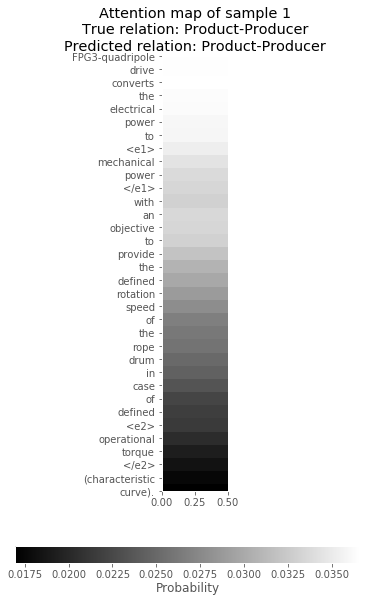

In [239]:
i = 1
activation_map = np.expand_dims(y_attn[i][:len(test_sent[i].split())], axis=1)

f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(1, 1, 1)

img = ax.imshow(activation_map, interpolation='none', cmap='gray')

plt.xlim([0,0.5])
ax.set_aspect(0.1)
ax.set_yticks(range(len(test_sent[i].split())))
ax.set_yticklabels(test_sent[i].split());
ax.grid()
plt.title("Attention map of sample {}\nTrue relation: {}\nPredicted relation: {}"
          .format(i, test_rel[i], rclf.encoder.classes_[y_pred[i]]));

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
cbar.ax.set_xlabel('Probability', labelpad=2);

In [240]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [241]:
y_test_pred = rclf.predict(test_sent)

In [242]:
label_idx_to_use = [i for i, c in enumerate(list(rclf.encoder.classes_)) if  c !="Other"]
label_to_use = list(rclf.encoder.classes_)
#label_to_use.remove("Other")

Check F1-score 

In [243]:
print("F1-Score: {:.1%}"
      .format(f1_score(rclf.encoder.transform(test_rel), y_test_pred,
                       average="macro", labels=label_idx_to_use)))

F1-Score: 50.1%


Due to lack of test sample we see that relations "Component-Whole" and "Product-Producer" have a low f1-score. 

In [244]:
print(classification_report(rclf.encoder.transform(test_rel), y_test_pred,
                            target_names=label_to_use,
                            labels=label_idx_to_use))

                    precision    recall  f1-score   support

      Cause-Effect       0.59      0.56      0.57        79
   Component-Whole       0.69      0.15      0.24        75
Entity-Destination       0.82      0.82      0.82        34
  Product-Producer       0.26      0.62      0.37        45

          accuracy                           0.48       233
         macro avg       0.59      0.54      0.50       233
      weighted avg       0.59      0.48      0.46       233

